In [2]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')

# print(jax.numpy.ones(3).device())

from jax.tree_util import tree_map

from matplotlib import colors, cm, pyplot as plt

import dLux as dl
from dLux.optics import OpticalLayer
from dLux.detectors import DetectorLayer

import jax.numpy as np
from jax.scipy.special import bessel_jn
from jax import custom_jvp, pure_callback, vmap, grad, jit

import numpy as onp

from scipy.special import jv

import webbpsf
import poppy
import pysiaf
import scipy
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm

from nircam_functions import *

Array = np.ndarray

In [3]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

<Figure size 640x480 with 0 Axes>

In [4]:
def get_osys(instrument, filtr, pup_mask, crn_mask, detector, aperture):
    webb_osys = getattr(webbpsf, instrument)()
    webb_osys.filter = filtr
    webb_osys.pupil_mask = pup_mask
    webb_osys.image_mask = crn_mask
    webb_osys.detector = detector

    # Siaf aperture
    aper = pysiaf.Siaf(instrument)[aperture]
    webb_osys.set_position_from_aperture_name(aperture)
    
    return webb_osys

In [5]:
def get_nircam(source_offset_x = 0, source_offset_y = 0):
    webb_osys = get_osys("NIRCam", "F300M", "CIRCLYOT", "MASK430R", "NRCA5", "NRCA5_FULL_MASK430R") #same as nc.
    webb_osys.options['jitter'] = None   # jitter model name or None
    webb_osys.options['jitter_sigma'] = 0.000  # in arcsec per axis, default 0.007
    webb_osys.options['add_distortion'] = False
    
    source_offset_r = np.sqrt(source_offset_x**2+ source_offset_y**2)
    source_offset_theta = np.arctan2(source_offset_y, source_offset_x)*180/np.pi
    
    #print(source_offset_r)
    #print(source_offset_theta)
    
    #print(source_offset_r * np.sin(source_offset_theta/180*np.pi))
    #print(source_offset_r * np.cos(source_offset_theta/180*np.pi))
    
    webb_osys.options['source_offset_r'] = source_offset_r
    webb_osys.options['source_offset_theta'] = source_offset_theta

    webb_osys.filter='F300M'
    webb_osys.image_mask='MASK430R'
    webb_osys.pupil_mask='CIRCLYOT'
    
    return webb_osys

# Override some of the defaults for get_optical_system to match calc_psf
# e.g. fov_arcsec for default get_optical_system is 2, whereas for calc_psf it is 5
def get_optical_system(webb_osys,
                       fft_oversample=4,
                       detector_oversample=None,
                       fov_arcsec=5,
                       fov_pixels=None,
                       options=None):
    return webb_osys.get_optical_system(fft_oversample=fft_oversample,
                                        detector_oversample=detector_oversample,
                                        fov_arcsec=fov_arcsec, fov_pixels=fov_pixels,
                                        options=options)

In [ ]:
webb_osys = get_nircam()

webb_osys.calc_psf('coronagraphic.fits', oversample=4) #, monochromatic=3.0e-6)   # create highly oversampled output image

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='OVERSAMP', title='NIRCam F300M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='DET_SAMP', title='NIRCam F300M+MASK430R, detector oversampled', crosshairs=True)

#plt.savefig('example_nircam_coron_resampling.png')

In [51]:
def calc_psf(offset_x, offset_y):
    osys = get_nircam(offset_x, offset_y)
    psf = osys.calc_psf(oversample=4)
    return psf[0].data

webb_planets = []

# webb_star = calc_psf(0, 0)

base_offset_x = (2 * u.arcsec).value
base_offset_y = (2 * u.arcsec).value

n = 10
for i in range(n):
    print(i)

    offset_y = base_offset_y - (base_offset_y / n * i)
    offset_x = base_offset_x - (base_offset_x / n * i)

    psf_i = calc_psf(offset_x, offset_y)
    webb_planets.append(psf_i)


onp.savez("planets_webbpsf", psf_star=webb_star, psf_planets=webb_planets)

0
1
2
3
4
5
6
7
8
9


In [6]:
hdul = fits.open('coronagraphic.fits')
hdul.info()

webbpsf_header = hdul[0].header
webbpsf_data_star = hdul[0].data

hdul.close()

Filename: coronagraphic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     123   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       124   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       168   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       169   (79, 79)   float64   


In [7]:
#generating source from fits file

head = webbpsf_header
nwavels = head['NWAVES']
wavels, weights = [], []
for i in range(nwavels):
    wavels.append(head['WAVE'+str(i)])
    weights.append(head['WGHT'+str(i)])

spec = dl.ArraySpectrum(wavels, weights)
source_star = dl.PointSource(spectrum=spec)
#source_planet = dl.PointSource(spectrum=spec, position=np.array([-source_offset_y.to(u.rad).value, -source_offset_x.to(u.rad).value]))

#source = dl.MultiPointSource(spectrum=spec,
#                             position=[(0,0), (-source_offset_y.to(u.rad).value, -source_offset_x.to(u.rad).value)],
#                             flux=[1, 0.01])

#source = dl.BinarySource(spectrum=dl.CombinedSpectrum(wavels, weights), separation=source_offset_y.to(u.rad).value, contrast=100)

source = source_star


In [8]:
webb_osys = get_nircam()
nircam = get_optical_system(webb_osys)
pupil_plane = nircam.planes[0]
det_plane = nircam.planes[-1]

In [9]:
# Wavefront 
npix = 1024
diameter = pupil_plane.pixelscale.to('m/pix').value * pupil_plane.npix

# Detector
det_npix = (det_plane.fov_pixels * det_plane.oversample).value
print(det_npix)
pscale = det_plane.pixelscale/det_plane.oversample
print(pscale)
pscale = pscale.to('radian/pix').value

# Make layers

def get_optical_layers():
    optical_layers = [
        #Plane 0: Pupil plane: JWST Entrance Pupil
        dl.CreateWavefront(npix, diameter, 'Angular'),
        dl.TransmissiveOptic(nircam.planes[0].amplitude),
        dl.AddOPD(nircam.planes[0].opd),

        #Plane 1: Coordinate Inversion in y axis
        InvertY(),

        #Plane 2: Image plane: MASK430R
        Pad(npix * nircam.planes[2].oversample),
        dl.AngularFFT(),
        NircamCirc(nircam.planes[2].sigma, diameter, npix, nircam.planes[2].oversample),
        dl.AngularFFT(inverse=True),
        Crop(npix),

        #Plane 3: Pupil plane: CIRCLYOT
        dl.TransmissiveOptic(nircam.planes[3].amplitude),

        #Plane 4: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A
        NIRCamFieldAndWavelengthDependentAberration(webb_osys, nircam.planes[4].opd, nircam.planes[4].zernike_coeffs),

        #Plane 5: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)
        dl.AngularMFT(det_npix, pscale)
    ]
    return optical_layers

optical_layers = get_optical_layers()

optics = dl.Optics(optical_layers)


316.0
0.01575 arcsec / pix
opd_ref_focus: {} 6.714345736893632e-08
tilt_ref_offset: {} 5.4124063812869335e-08


In [33]:
psf_planets = []

@jit
def optics_model_offset(offset_x, offset_y):
    source = dl.PointSource(spectrum=spec, position=np.array([-offset_y, -offset_x]))
    return optics.model(source=source)

psf_star = optics_model_offset(0,0)

base_offset_x = (2 * u.arcsec).to(u.rad).value
base_offset_y = (2 * u.arcsec).to(u.rad).value

n = 30
for i in range(n):
    print(i)

    offset_y = base_offset_y - (base_offset_y / n * i)
    offset_x = base_offset_x - (base_offset_x / n * i)

    psf_i = optics_model_offset(offset_x, offset_y)
    psf_planets.append(psf_i)

onp.savez("planets", psf_star=psf_star, psf_planets=psf_planets)

2023-04-11 16:24:18.622018: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  dynamic-update-slice.10 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-04-11 16:24:18.782353: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.160988s
Constant folding an instruction is taking > 1s:

  dynamic-update-slice.10 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [53]:
#psf_load = onp.load("planets.npz")
psf_load = onp.load("planets_webbpsf.npz")
psf_star = psf_load["psf_star"]
psf_planets = psf_load["psf_planets"]

In [54]:

psf_all = onp.array([psf_star + pp/100 for pp in psf_planets])

psf_mean = psf_all.mean(axis=0)

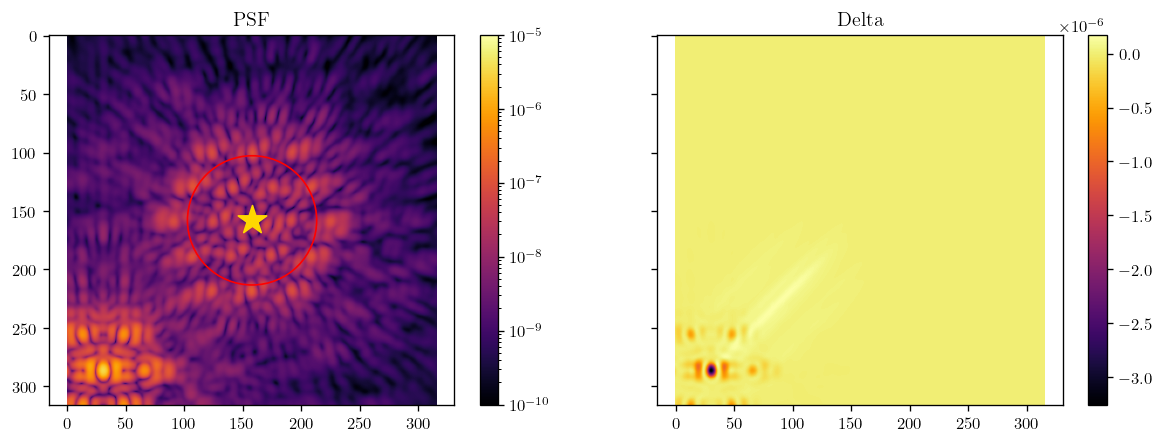

In [36]:
from matplotlib import animation

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))

# fig = plt.figure(figsize=(12, 4))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 4))
ax1.set_aspect('equal', 'datalim')
ax2.set_aspect('equal', 'datalim')

deltas = [psf_mean - p for p in psf_all]

centre = onp.array(psf_mean.shape) / 2
scale = 0.01575 #arcsec/px
iwa_size = 0.87 / scale

circle2 = plt.Circle((centre[0], centre[1]), iwa_size, color='r', fill=False)
ax1.add_patch(circle2)
ax1.scatter(centre[0], centre[1], s=320, marker='*', color='gold', zorder=3)

im1 = ax1.imshow(psf_all[0], norm=norm)
cb1 = fig.colorbar(im1, ax=ax1)
tx1 = ax1.set_title('PSF')

im2 = ax2.imshow(deltas[0])
cb2 = fig.colorbar(im2, ax=ax2)
tx2 = ax2.set_title('Delta')

plt.show()

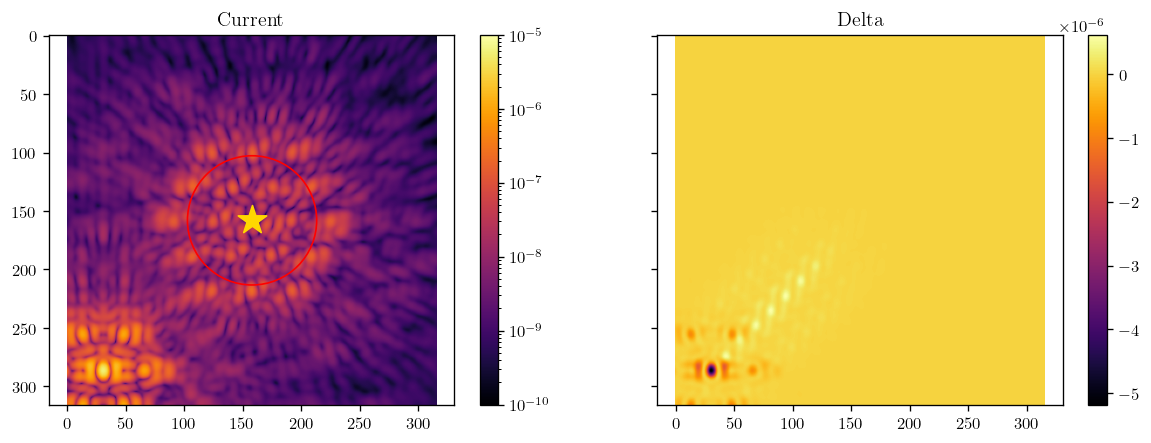

In [55]:
#%matplotlib ipympl
from matplotlib import animation

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 4))
ax1.set_aspect('equal', 'datalim')
ax2.set_aspect('equal', 'datalim')

deltas = [psf_mean - p for p in psf_all]

centre = onp.array(psf_mean.shape) / 2
scale = 0.01575 #arcsec/px
iwa_size = 0.87 / scale

circle2 = plt.Circle((centre[0], centre[1]), iwa_size, color='r', fill=False)
ax1.add_patch(circle2)
ax1.scatter(centre[0], centre[1], s=320, marker='*', color='gold', zorder=3)

im1 = ax1.imshow(psf_all[0], norm=norm)
cb1 = fig.colorbar(im1, ax=ax1)
tx1 = ax1.set_title('Current')

im2 = ax2.imshow(deltas[0])
cb2 = fig.colorbar(im2, ax=ax2)
tx2 = ax2.set_title('Delta')

def animate(i):
    p1 = psf_all[i]
    im1.set_data(p1)
    #im1.set_clim(np.min(p1), np.max(p1))

    p2 = deltas[i]
    im2.set_data(p2)
    #im2.set_clim(np.min(p2), np.max(p2))
    tx2.set_text('Delta Frame {0}'.format(i))

anim = animation.FuncAnimation(fig, animate, frames=len(psf_all), interval=200)

plt.show()

writergif = animation.PillowWriter(fps=3) 
anim.save("animation.gif", writer=writergif)
#anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

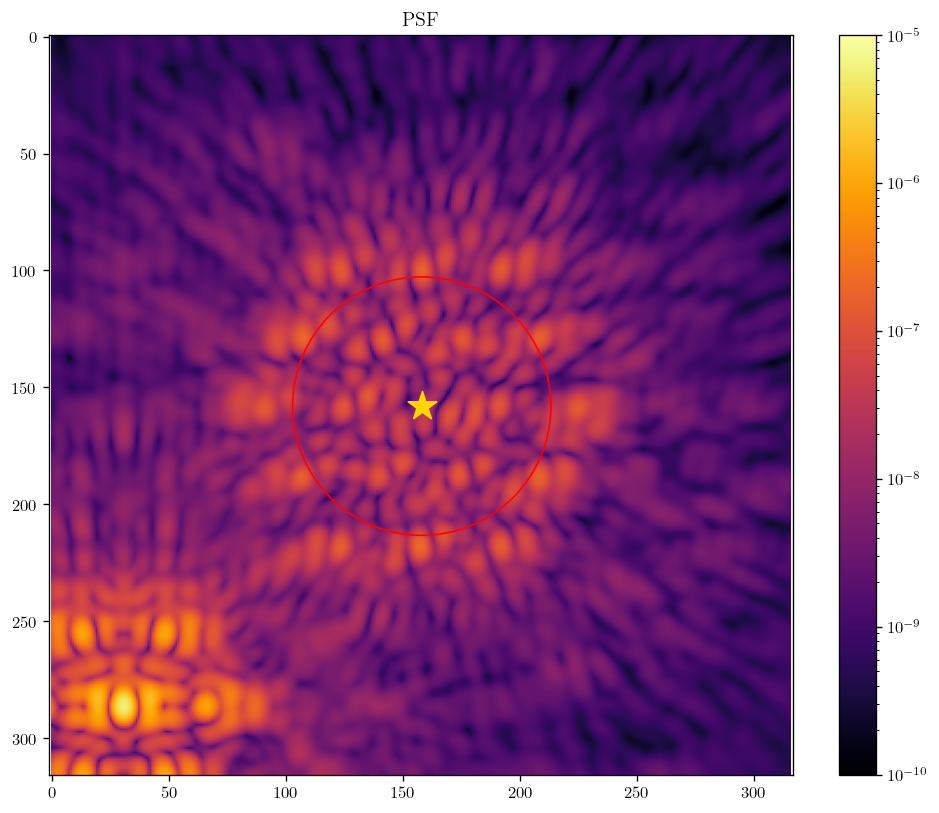

In [56]:
#%matplotlib ipympl
from matplotlib import animation

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))

fig, ax1 = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))
ax1.set_aspect('equal', 'datalim')

deltas = [psf_mean - p for p in psf_all]

centre = onp.array(psf_mean.shape) / 2
scale = 0.01575 #arcsec/px
iwa_size = 0.87 / scale

circle2 = plt.Circle((centre[0], centre[1]), iwa_size, color='r', fill=False)
ax1.add_patch(circle2)
ax1.scatter(centre[0], centre[1], s=320, marker='*', color='gold', zorder=3)

im1 = ax1.imshow(psf_all[0], norm=norm)
cb1 = fig.colorbar(im1, ax=ax1)
tx1 = ax1.set_title('PSF')


def animate(i):
    p1 = psf_all[i]
    im1.set_data(p1)
    #im1.set_clim(np.min(p1), np.max(p1))


anim = animation.FuncAnimation(fig, animate, frames=len(psf_all), interval=200)

plt.show()

writergif = animation.PillowWriter(fps=5) 
anim.save("animation_webbpfs.gif", writer=writergif)
#anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])